# Amazon Fine Food Reviews 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import datasets, neighbors
from sklearn.linear_model import LogisticRegression
from scipy import *
from scipy.sparse import *
from gensim.models import Word2Vec
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

c:\program files\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
conn = sqlite3.connect('final.sqlite')

In [3]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [4]:
data.shape

(364171, 12)

## Sorting the DataFrame using Time Column:

In [5]:
data = data.sort_values(by='Time')
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


## Preparing the data :

> Seperating training data and values to predict.

In [6]:
# Getting the column names
cols = data.columns
cols = cols[cols != 'Score']
# Train data excluding the score column
X = data[cols]
# Score coumn
Y = data['Score']
# Maping positive as 1 and negative as 0
mapping_dict = {'positive': 1, 'negative': 0}
labels = ['negative', 'positive']
# Mapping is done as some metrics dont work with string so a value of 1 or 0 is given to positive or negative.
Y = Y.map(mapping_dict)

## Time Based Splitting :
> Splitting the data into 70% train data and 30% test data.

In [7]:
X_train = X[:int((0.7) * X.shape[0])]
X_cv = X_train[int(0.7 * X_train.shape[0]):]
X_train = X_train[:int((0.7) * X_train.shape[0])]
X_test = X[int((0.7) * X.shape[0]):]

print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(178443, 11)
(76476, 11)
(109252, 11)


In [8]:
y_train = Y[:int((0.7) * X.shape[0])]
y_cv = y_train[ int(0.7 * y_train.shape[0]) : ]
y_train = y_train[ : int((0.7) * y_train.shape[0]) ]
y_test = Y[int((0.7) * X.shape[0]) : ]

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(178443,)
(76476,)
(109252,)


## Tasks to do :

Three main Tasks :
1. Apply Logistics Regression on BoW, TFIDF, AVGW2V, TFIDF W2V.
2. Hyperparameter tune the model.
3. Get important features.

### Bag of Words :

In [9]:
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(X_train['CleanedText'].values)
bow_train.shape

(178443, 49468)

In [10]:
bow_cv = count_vect.transform(X_cv['CleanedText'])
bow_cv.shape

(76476, 49468)

In [11]:
bow_test = count_vect.transform(X_test['CleanedText'].values)
bow_test.shape

(109252, 49468)

##### Hyperparameter tuning :

In [12]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        clf = LogisticRegression(penalty=p, C=alpha)
        clf.fit(bow_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(bow_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(bow_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.6030323423456887  Train ROC_AUC Score :  0.5918217326055184 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.7770084150956468  Train ROC_AUC Score :  0.7651586717071146 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8508390236976879  Train ROC_AUC Score :  0.8417477048045323 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.8033579389078852  Train ROC_AUC Score :  0.7967919721961861 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.9205276652348735  Train ROC_AUC Score :  0.9174302154559966 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.9193246141079783  Train ROC_AUC Score :  0.9127375419033545 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.9395685993226462  Train ROC_AUC Score :  0.9430225472937468 C :  0.01  penalty :  l2
CV ROC_AUC

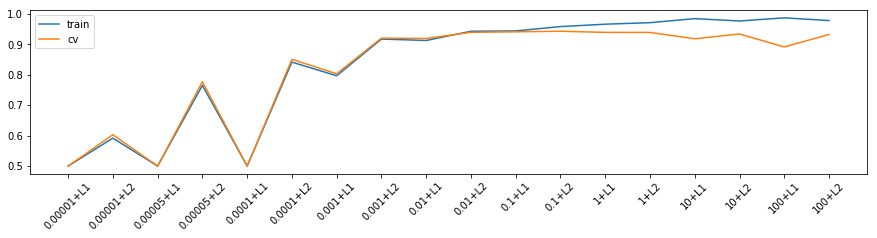

In [15]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

> Best combination of C and penalty is : 0.1 C and l2 penalty

In [16]:
model = LogisticRegression(C=0.1, penalty='l2')
model.fit(bow_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

##### Test metrics :

In [17]:
# Plots confusion matrix using heatmap and calculates and displays TN,FN,TP,FP
def plot_confusion_matrix(y_actual, y_predicted):
    cm = confusion_matrix(y_predicted, y_actual)
    df = pd.DataFrame(data=cm, index=labels, columns=labels)
    print("Confusion Matrix : ")
    plt.figure(figsize=(10,7))
    sns.heatmap(df, annot=True)
    plt.show()
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_predicted)): 
        if y_actual[i]== 1 and y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_actual[i]!=y_predicted[i]:
            FP += 1
        if y_actual[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_actual[i]!=y_predicted[i]:
            FN += 1
            
    print("True Positives :", TP)
    print("False Positives :", FP)
    print("True Negatives :", TN)
    print("False Negatives :", FN)

In [18]:
y_pred = model.predict(bow_test)

Confusion Matrix : 


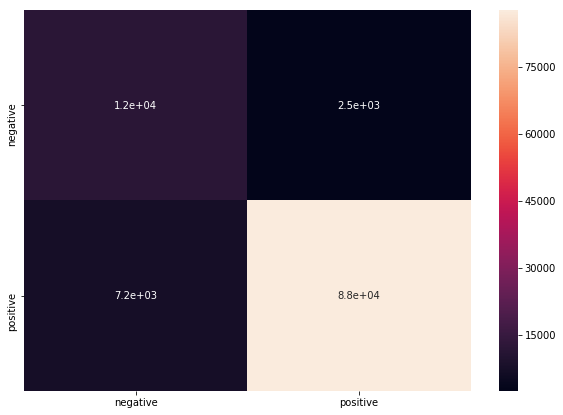

True Positives : 87675
False Positives : 7203
True Negatives : 11878
False Negatives : 2496


In [19]:
plot_confusion_matrix(np.array(y_test), y_pred)

In [20]:
# Printing roc_auc score
y_pred = model.predict_proba(bow_test)
roc_auc_score(y_true=y_test, y_score=y_pred[:,1])

0.9401458322305265

##### Checking sparsity :

In [21]:
C_sparse = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
C_sparse.shape

(6,)

In [22]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(bow_train, y_train)
    error.append(1- m.score(bow_test, y_test))
    spc.append(np.count_nonzero(m.coef_))
    print("For c:", c, "  NonZero coefficients :", np.count_nonzero(m.coef_))

For c: 0.0001   NonZero coefficients : 0
For c: 0.001   NonZero coefficients : 27
For c: 0.01   NonZero coefficients : 310
For c: 0.1   NonZero coefficients : 1486
For c: 1.0   NonZero coefficients : 6789
For c: 10.0   NonZero coefficients : 17301


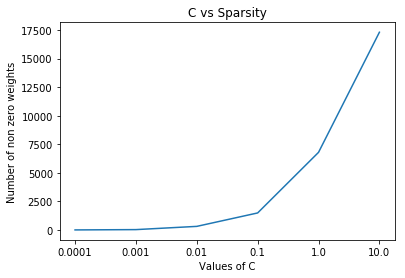

In [23]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), spc)
plt.show()

> As the regulaization strength decreases or C increase the number of non zero weights increase.

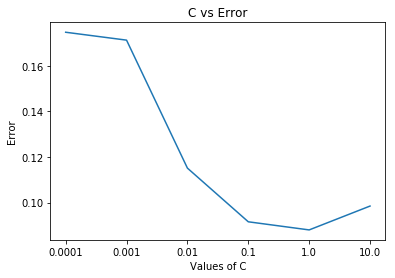

In [24]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), error)
plt.show()

> As regularization strength decrease the error is increasing, so regularization is preventing overfitting of LR Model.

##### Feature Importance:

In [25]:
# Creating a dataframe with feature - weights.
df = pd.DataFrame(data=model.coef_.reshape(-1,1), index=count_vect.get_feature_names())

In [26]:
# Top 10 negative feature coefficients..
df.sort_values(by = 0).head(10)

,0
worst,-2.415767
terribl,-1.755508
aw,-1.625560
horribl,-1.579208
disappoint,-1.501832
threw,-1.446667
tasteless,-1.419774
disgust,-1.404928
yuck,-1.351462
bland,-1.347544


In [27]:
# Top 10 positive features :
df.sort_values(by = 0, ascending=False).head(10)

,0
delici,1.561867
excel,1.405759
amaz,1.327336
perfect,1.326261
hook,1.313772
addict,1.283823
awesom,1.265760
yummi,1.239095
beat,1.238024
skeptic,1.232962


##### Perturbation Test :

In [28]:
# Adding noise to csr matrix
epsilon = 0.00005
bow_train_2 = bow_train.data + epsilon
bow_train_2.shape

(5553632,)

In [29]:
# Converting to CSR_Matrix..
bow_train_2 = csr_matrix((bow_train_2, bow_train.indices, bow_train.indptr), shape=bow_train.shape)
bow_train_2.shape

(178443, 49468)

In [30]:
model_2 = LogisticRegression(C=0.1, penalty='l2')
model_2.fit(bow_train_2, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
# Finding percentage change :
# Adding a very small value to avoid divison by zero error
w = model.coef_ + 0.0000001
w_dash = model_2.coef_

# Percentage change = (original - changed)/original * 100
diff = w - w_dash
change = diff*1.0/w
percentage_change = change * 100
percentage_change = percentage_change[0]
percentage_change.shape

(49468,)

In [32]:
# Printing Percentiles :
for i in range(10, 101, 10):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(percentage_change, i)))

 10th Percentile value : -0.01630
 20th Percentile value : -0.01234
 30th Percentile value : -0.00919
 40th Percentile value : -0.00605
 50th Percentile value : -0.00279
 60th Percentile value : 0.00092
 70th Percentile value : 0.00631
 80th Percentile value : 0.02403
 90th Percentile value : 0.15188
100th Percentile value : 17632.76550


> We see that there is a abrupt change when going from 90th percentile to 100th percentile.

In [33]:
# Printing close percentiles :
for i in range(91, 101, 1):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(percentage_change, i)))

 91th Percentile value : 0.20115
 92th Percentile value : 0.27799
 93th Percentile value : 0.40031
 94th Percentile value : 0.64472
 95th Percentile value : 1.08919
 96th Percentile value : 2.21258
 97th Percentile value : 6.11973
 98th Percentile value : 20.03829
 99th Percentile value : 87.13591
100th Percentile value : 17632.76550


In [34]:
# Lookign at 99.1, 99.2 percentiles :
for i in range(1, 11, 1):
    print("{:.1f}th Percentile value :{:.5f}".format(i*1.0/10 + 99, np.percentile(percentage_change, i*1.0/10 + 99)))

99.1th Percentile value :94.83285
99.2th Percentile value :101.88830
99.3th Percentile value :107.80067
99.4th Percentile value :113.59370
99.5th Percentile value :124.59235
99.6th Percentile value :135.30181
99.7th Percentile value :157.90281
99.8th Percentile value :192.05636
99.9th Percentile value :284.09278
100.0th Percentile value :17632.76550


> We see that there is an abrupt change from 99.9th percentile to 100th percentile. Let' see what these values are :

In [35]:
# Creating dataframe of percentage change..
percendf = pd.DataFrame(percentage_change, index = count_vect.get_feature_names(), columns=['%Change'])
percendf.head(2)

,%Change
aa,-0.012965
aaa,0.001329


In [36]:
# Getting those features/words where the percentage change is more than 335% .
percendf = percendf[percendf['%Change'] > 284]
percendf.shape

(50, 1)

In [37]:
percendf.sort_values(by='%Change', ascending=False, inplace=True)
percendf.tail(5)

,%Change
powerse,307.137996
lamington,305.293921
cooconut,305.293921
hao,294.219320
effronteri,286.243729


#### Conclusions for BoW:

1. CV auc_roc score - 0.9583
2. Test auc_roc score - 0.9401
3. From feature importance we see that if a review contains the word <b style="color:red">worst</b> then it is likely a negative review.
4. From feature importance we see that if a review contaisn the word <b style="color:green">delici</b> then it is more likely to be positive review.
5. From perturbation test we see that there are many features where the percentage change is a whole lot more. Some feature are - powerse, lamington etc.

### TFIDF :

In [38]:
# Generating TFIDF features.
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(X_train['CleanedText'].values)
tf_train.shape

(178443, 49468)

In [39]:
tf_cv = tfidf.transform(X_cv['CleanedText'].values)
tf_cv.shape

(76476, 49468)

In [40]:
tf_test = tfidf.transform(X_test['CleanedText'].values)
tf_test.shape

(109252, 49468)

##### Hyperparameter tuning :

In [41]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        clf = LogisticRegression(penalty=p, C=alpha)
        clf.fit(tf_train, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(tf_cv)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(tf_train)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.6774983648669006  Train ROC_AUC Score :  0.6698887726199152 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.7542288564198806  Train ROC_AUC Score :  0.7454850770616036 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8110593172448647  Train ROC_AUC Score :  0.802760294027889 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.9105174475355713  Train ROC_AUC Score :  0.907124307840478 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.8451948122113099  Train ROC_AUC Score :  0.8379936201686762 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.9255010726199832  Train ROC_AUC Score :  0.9234204803877508 C :  0.01  penalty :  l2
CV ROC_AUC Score :  0.9376961402009798  Tr

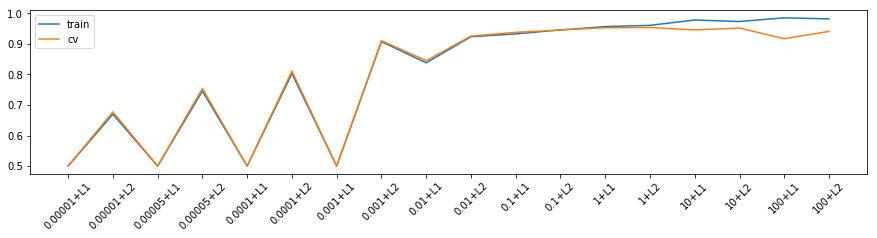

In [72]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [42]:
model = LogisticRegression(C=1, penalty='l2')
model.fit(tf_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

##### Test Metrics :

Confusion Matrix : 


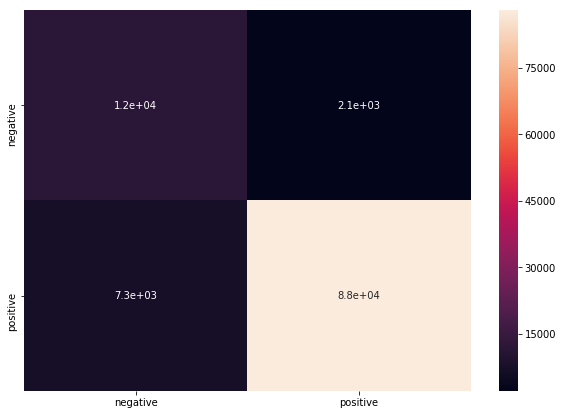

True Positives : 88045
False Positives : 7259
True Negatives : 11822
False Negatives : 2126


In [43]:
y_pred = model.predict(tf_test)
plot_confusion_matrix(np.array(y_test), y_pred)

In [44]:
# Printing roc_auc score
y_pred = model.predict_proba(tf_test)[:,1]
roc_auc_score(y_true=y_test, y_score=y_pred)

0.9504780141159408

##### Checking sparsity :

In [45]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(tf_train, y_train)
    error.append(1- m.score(tf_test, y_test))
    spc.append(np.count_nonzero(m.coef_))
    print("For c:", c, "  NonZero coefficients :", np.count_nonzero(m.coef_))

For c: 0.0001   NonZero coefficients : 0
For c: 0.001   NonZero coefficients : 0
For c: 0.01   NonZero coefficients : 36
For c: 0.1   NonZero coefficients : 440
For c: 1.0   NonZero coefficients : 2427
For c: 10.0   NonZero coefficients : 12747


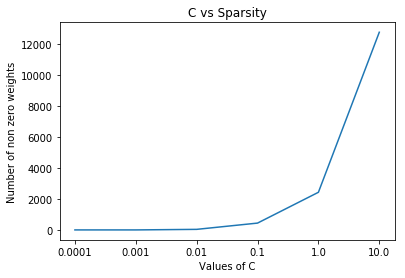

In [46]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), spc)
plt.show()

> Non zero weights increase as regularization strength decrease.

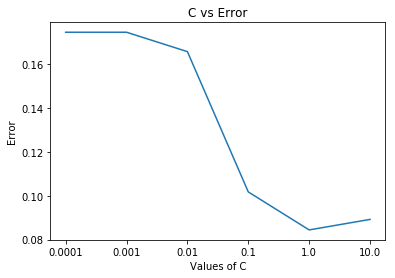

In [47]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), error)
plt.show()

##### Feature Importance:

In [48]:
# Creating a dataframe with feature - weights.
df = pd.DataFrame(data=model.coef_.reshape(-1,1), index=tfidf.get_feature_names())

In [49]:
# Top 10 negative feature coefficients..
df.sort_values(by = 0).head(10)

,0
worst,-10.199662
disappoint,-8.556547
terribl,-7.792601
aw,-7.308264
horribl,-7.142684
threw,-6.256774
unfortun,-6.163699
disgust,-6.135713
bland,-5.954374
return,-5.925929


In [50]:
# Top 10 positive features :
df.sort_values(by = 0, ascending=False).head(10)

,0
great,12.207917
delici,10.397972
best,10.368612
love,9.256229
perfect,8.808885
excel,8.288287
amaz,6.919878
good,6.345056
nice,6.240103
favorit,6.097244


> Reviews containing the words like <b style="color:red">worst, disappoint, return, disgust</b> etc. are likely to be negative reviews.

> Reviews containing the words like <b style="color:green">great, delici, best, prefect, love</b> etc. are likely to be positive reviews.

##### Perturbation Test :

In [51]:
# Adding noise to csr matrix
epsilon = 0.000001
tf_train_2 = tf_train.data + epsilon
tf_train_2.shape

(5553632,)

In [52]:
# Converting to CSR_Matrix..
tf_train_2 = csr_matrix((tf_train_2, tf_train.indices, tf_train.indptr), shape=tf_train.shape)
tf_train_2.shape

(178443, 49468)

In [53]:
model_2 = LogisticRegression(C=1, penalty='l2')
model_2.fit(tf_train_2, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
# Finding percentage change :
# Adding a very small value to avoid divison by zero error
w = model.coef_ + 0.0000001
w_dash = model_2.coef_

# Percentage change = (original - changed)/original * 100
diff = w - w_dash
change = diff*1.0/w
percentage_change = change * 100
percentage_change = percentage_change[0]
percentage_change.shape

(49468,)

In [55]:
# Printing Percentiles :
for i in range(10, 101, 10):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(percentage_change, i)))
    
print("*"*50)
# Printing close percentiles :
for i in range(91, 101, 1):
    print("{:3d}th Percentile value : {:.5f}".format(i, np.percentile(percentage_change, i)))
    
print("*"*50)
# Lookign at 99.1, 99.2 percentiles :
for i in range(1, 11, 1):
    print("{:.1f}th Percentile value : {:.5f}".format(i*1.0/10 + 99, np.percentile(percentage_change, i*1.0/10 + 99)))

 10th Percentile value : -0.04740
 20th Percentile value : -0.03812
 30th Percentile value : -0.03132
 40th Percentile value : -0.02525
 50th Percentile value : -0.01924
 60th Percentile value : -0.01291
 70th Percentile value : -0.00611
 80th Percentile value : 0.00095
 90th Percentile value : 0.01994
100th Percentile value : 88.16294
**************************************************
 91th Percentile value : 0.02437
 92th Percentile value : 0.02910
 93th Percentile value : 0.03432
 94th Percentile value : 0.04111
 95th Percentile value : 0.04891
 96th Percentile value : 0.06029
 97th Percentile value : 0.07593
 98th Percentile value : 0.10326
 99th Percentile value : 0.17903
100th Percentile value : 88.16294
**************************************************
99.1th Percentile value : 0.19289
99.2th Percentile value : 0.20973
99.3th Percentile value : 0.23366
99.4th Percentile value : 0.27577
99.5th Percentile value : 0.32267
99.6th Percentile value : 0.37441
99.7th Percentile value :

In [56]:
# Creating dataframe of percentage change..
percendf = pd.DataFrame(percentage_change, index = count_vect.get_feature_names(), columns=['%Change'])
percendf.head(2)

,%Change
aa,-0.031585
aaa,-0.008627


In [57]:
# Getting those features/words where the percentage change is more than 335% .
percendf = percendf[percendf['%Change'] > 1]
percendf.shape

(50, 1)

In [58]:
percendf.sort_values(by='%Change', ascending=False, inplace=True)
percendf.tail(5)

,%Change
brunell,1.055876
yami,1.043136
brough,1.039905
goop,1.031363
driveway,1.013042


#### Conclusions for TFIDF :

1. Cv roc_auc score - 0.9534.
2. Test roc_auc score - 0.9504.

## Word2Vec :
* We will train W2V on our train dataset.

In [59]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_train=[]
for sentance in X_train['CleanedText']:
    list_of_sent_train.append(sentance.split())

In [60]:
i=0
list_of_sent_test=[]
for sentance in X_test['CleanedText']:
    list_of_sent_test.append(sentance.split())

In [62]:
i=0
list_of_sent_cv=[]
for sentance in X_cv['CleanedText']:
    list_of_sent_cv.append(sentance.split())

In [63]:
print(len(list_of_sent_train))
print(len(list_of_sent_cv))
print(len(list_of_sent_test))

178443
76476
109252


In [64]:
def convertByteStringtoString(sentlist):
    for x in sentlist:
        for i in range(len(x)):
            x[i] = x[i].decode("utf-8")
            
    return sentlist

In [65]:
list_of_sent_train = convertByteStringtoString(list_of_sent_train)
list_of_sent_cv = convertByteStringtoString(list_of_sent_cv)
list_of_sent_test = convertByteStringtoString(list_of_sent_test)

In [66]:
# Training word 2 vec on our train set --
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=100, workers=4)

In [67]:
w2v_words = list(w2v_model.wv.vocab)

In [68]:
list_of_sent_train = np.array(list_of_sent_train)
list_of_sent_cv = np.array(list_of_sent_cv)
list_of_sent_test = np.array(list_of_sent_test)

In [69]:
np.save("train_sent.npy", list_of_sent_train)
np.save("cv_sent.npy", list_of_sent_cv)
np.save("test_sent.npy", list_of_sent_test)

### Average W2V :

In [70]:
def avgw2vvectors(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent): # for each review/sentence
        sent_vec = np.zeros(100) # as word vectors are of zero length 200, you might need to change this to 300 if you use google's w2v
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [71]:
train_avgw2v = avgw2vvectors(list_of_sent_train)

178443
100


In [73]:
cv_avgw2v = avgw2vvectors(list_of_sent_cv)

76476
100


In [74]:
test_avgw2v = avgw2vvectors(list_of_sent_test)

109252
100


In [75]:
train_avgw2v = np.array(train_avgw2v)
cv_avgw2v = np.array(cv_avgw2v)
test_avgw2v = np.array(test_avgw2v)

np.save("train_avgw2v", train_avgw2v)
np.save("cv_avgw2v", cv_avgw2v)
np.save("test_avgw2v", test_avgw2v)

In [76]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        clf = LogisticRegression(penalty=p, C=alpha)
        clf.fit(train_avgw2v, y_train)
        scores = roc_auc_score(y_true=np.array(y_cv), y_score=clf.predict_proba(cv_avgw2v)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_train), y_score=clf.predict_proba(train_avgw2v)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.730128694570964  Train ROC_AUC Score :  0.7288374254527659 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.855322243653259  Train ROC_AUC Score :  0.8499868055499507 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.6995269112805782  Train ROC_AUC Score :  0.696582085201208 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.8872931198978931  Train ROC_AUC Score :  0.8816280556814818 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.9067098440500955  Train ROC_AUC Score :  0.8996497777514741 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.922669972833725  Train ROC_AUC Score :  0.916697574580911 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.9269093810035562  Train ROC_AUC Score :  0.9204214690963264 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.9281365495530337  Train ROC_AUC Score :  0.92189279466163 C :  0.01  p

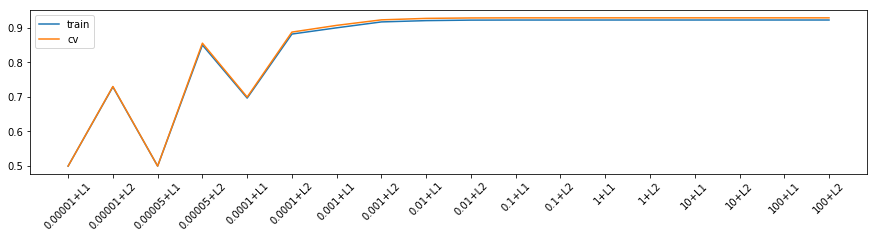

In [77]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [78]:
model = LogisticRegression(C=1, penalty='l2')
model.fit(train_avgw2v, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

##### Test Metrics :

Confusion Matrix : 


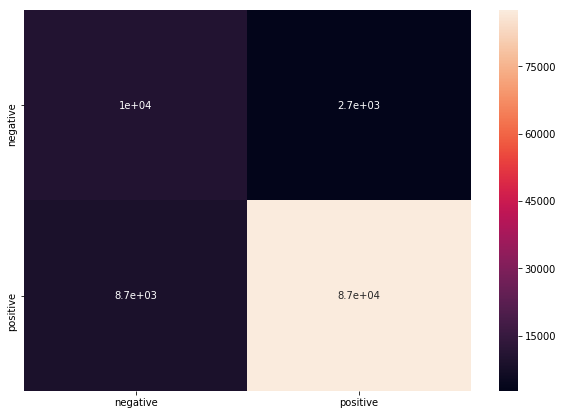

True Positives : 87452
False Positives : 8742
True Negatives : 10339
False Negatives : 2719


In [79]:
y_pred = model.predict(test_avgw2v)
plot_confusion_matrix(np.array(y_test), y_pred)

In [80]:
# Printing roc_auc score
y_pred = model.predict_proba(test_avgw2v)[:,1]
roc_auc_score(y_true=y_test, y_score=y_pred)

0.9234095198392717

##### Sparsity :

In [81]:
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(train_avgw2v, y_train)
    error.append(1- m.score(test_avgw2v, y_test))
    spc.append(np.count_nonzero(m.coef_))
    print("For c:", c, "  NonZero coefficients :", np.count_nonzero(m.coef_))

For c: 0.0001   NonZero coefficients : 1
For c: 0.001   NonZero coefficients : 25
For c: 0.01   NonZero coefficients : 77
For c: 0.1   NonZero coefficients : 97
For c: 1.0   NonZero coefficients : 99
For c: 10.0   NonZero coefficients : 100


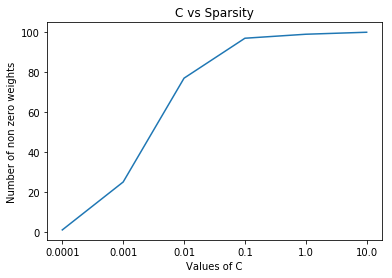

In [82]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), spc)
plt.show()

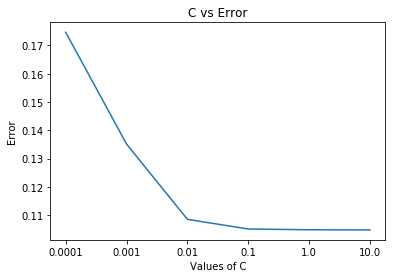

In [83]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), error)
plt.show()

##### Pertubation Test :

In [84]:
# Adding noise to matrix
epsilon = 0.000001
train_avgw2v_2 = np.array(train_avgw2v) + epsilon

In [85]:
model_2 = LogisticRegression(C=1, penalty='l2')
model_2.fit(train_avgw2v_2, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [86]:
# Finding percentage change :
# Adding a very small value to avoid divison by zero error
w = model.coef_ + 0.0000001
w_dash = model_2.coef_

# Percentage change = (original - changed)/original * 100
diff = w - w_dash
change = diff*1.0/w
percentage_change = change * 100
percentage_change = percentage_change[0]

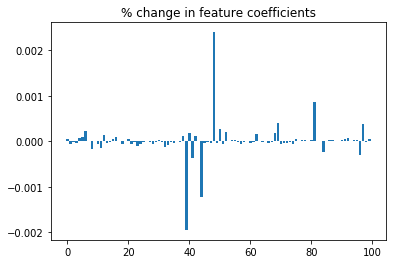

In [88]:
plt.bar(height=percentage_change, x = [i for i in range(len(percentage_change))])
plt.title("% change in feature coefficients")
plt.show()

### TFIDF W2V :

In [89]:
Everything = np.load('train_sent.npy')
list_of_sent_train = Everything[:80000]
list_of_sent_cv = list_of_sent_train[60000:80000]
list_of_sent_train = list_of_sent_train[:60000]
list_of_sent_test = Everything[80000:100000]

print(len(list_of_sent_train))
print(len(list_of_sent_cv))
print(len(list_of_sent_test))

60000
20000
20000


In [99]:
y_tfidf_train = np.array(y_train[:60000])
y_tfidf_cv = np.array(y_train[60000:80000])
y_tfidf_test = np.array(y_train[80000:100000])

np.save("y_tfidf_train", y_tfidf_train)
np.save("y_tfidf_cv", y_tfidf_cv)
np.save("y_tfidf_test", y_tfidf_test)

print(y_tfidf_train.shape)
print(y_tfidf_cv.shape)
print(y_tfidf_test.shape)

(60000,)
(20000,)
(20000,)


In [90]:
# Training word 2 vec on our train set --
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)

In [91]:
w2v_words = list(w2v_model.wv.vocab)

In [92]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.loc[:60000, 'CleanedText'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [93]:
def tfidfw2v(list_of_sent):
    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1
    
    return np.array(tfidf_sent_vectors)

In [94]:
train_tfidf = tfidfw2v(list_of_sent_train)
train_tfidf.shape

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [43:11<00:00, 27.07it/s]


(60000, 50)

In [95]:
cv_tfidf = tfidfw2v(list_of_sent_cv)
cv_tfidf.shape

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [13:47<00:00, 24.17it/s]


(20000, 50)

In [96]:
test_tfidf = tfidfw2v(list_of_sent_test)
test_tfidf.shape

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [13:31<00:00, 24.65it/s]


(20000, 50)

In [97]:
np.save("train_tfidf", train_tfidf)
np.save("cv_tfidf", cv_tfidf)
np.save("test_tfidf", test_tfidf)

In [100]:
# Hyperparameter tuning :
penalties = ['l1', 'l2']
C = [0.00001, 0.00005, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_scores = []
tr_scores = []
i = 0
for alpha in C:
    for p in penalties:
        clf = LogisticRegression(penalty=p, C=alpha)
        clf.fit(train_tfidf, y_tfidf_train)
        scores = roc_auc_score(y_true=np.array(y_tfidf_cv), y_score=clf.predict_proba(cv_tfidf)[:,1])
        cv_scores.append(scores)
        scores = roc_auc_score(y_true=np.array(y_tfidf_train), y_score=clf.predict_proba(train_tfidf)[:,1])
        tr_scores.append(scores)
        print("CV ROC_AUC Score : ", cv_scores[i], " Train ROC_AUC Score : ", tr_scores[i], "C : ", alpha, " penalty : ", p)
        i += 1

CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  1e-05  penalty :  l1
CV ROC_AUC Score :  0.6370270064534682  Train ROC_AUC Score :  0.6236325467845295 C :  1e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  5e-05  penalty :  l1
CV ROC_AUC Score :  0.6978465673131413  Train ROC_AUC Score :  0.6829314018983841 C :  5e-05  penalty :  l2
CV ROC_AUC Score :  0.5  Train ROC_AUC Score :  0.5 C :  0.0001  penalty :  l1
CV ROC_AUC Score :  0.7456326175030238  Train ROC_AUC Score :  0.7314063784131011 C :  0.0001  penalty :  l2
CV ROC_AUC Score :  0.766765336502271  Train ROC_AUC Score :  0.7577576471565224 C :  0.001  penalty :  l1
CV ROC_AUC Score :  0.85483864214969  Train ROC_AUC Score :  0.849392342422063 C :  0.001  penalty :  l2
CV ROC_AUC Score :  0.8618238448461063  Train ROC_AUC Score :  0.8593654410792292 C :  0.01  penalty :  l1
CV ROC_AUC Score :  0.8669470781774662  Train ROC_AUC Score :  0.8638521749011565 C :  0.01  penalty :  l2
CV ROC_AUC Sco

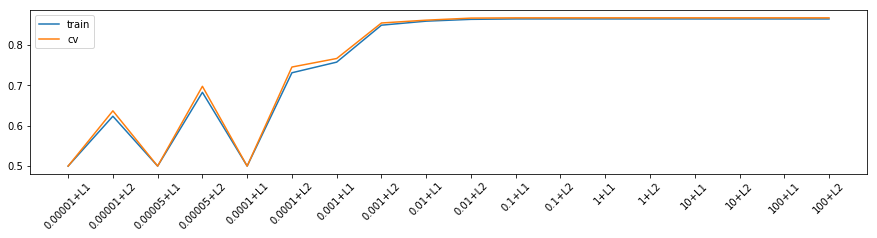

In [101]:
ticks = ['0.00001+L1', '0.00001+L2', '0.00005+L1', '0.00005+L2', '0.0001+L1', '0.0001+L2', '0.001+L1', '0.001+L2',
         '0.01+L1', '0.01+L2', '0.1+L1', '0.1+L2', '1+L1', '1+L2', '10+L1', '10+L2', '100+L1', '100+L2']
plt.figure(figsize=(15,3))
plt.plot(range(len(C)*len(penalties)), tr_scores)
plt.plot(range(len(C)*len(penalties)), cv_scores)
plt.xticks(range(len(C)*len(penalties)), ticks, rotation = 45)
plt.legend(['train', 'cv'])
plt.show()

In [102]:
model = LogisticRegression(C=1, penalty='l2')
model.fit(train_tfidf, y_tfidf_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

##### Test Metrics :

Confusion Matrix : 


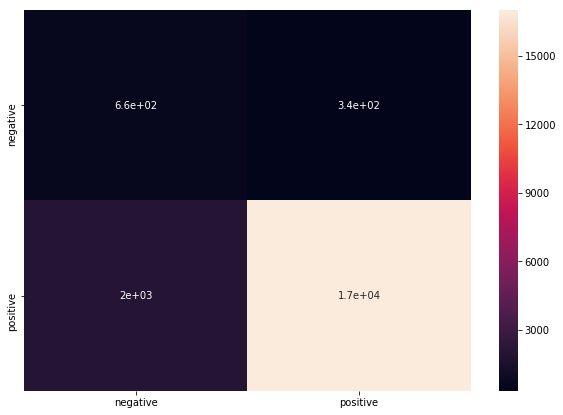

True Positives : 16981
False Positives : 2016
True Negatives : 662
False Negatives : 341


In [103]:
y_pred = model.predict(test_tfidf)
plot_confusion_matrix(y_tfidf_test, y_pred)

In [104]:
# Printing roc_auc score
y_pred = model.predict_proba(test_tfidf)[:,1]
roc_auc_score(y_true=y_tfidf_test, y_score=y_pred)

0.8665249995278985

##### Sparsity :

In [106]:
C_sparse = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
spc = [] # Counts number of non zero weights for a given C.
error = [] # This wll store error for each val of C
for c in C_sparse:
    m = LogisticRegression(penalty='l1', C=c)
    m.fit(train_tfidf, y_tfidf_train)
    error.append(1- m.score(test_tfidf, y_tfidf_test))
    spc.append(np.count_nonzero(m.coef_))
    print("For c:", c, "  NonZero coefficients :", np.count_nonzero(m.coef_))

For c: 0.0001   NonZero coefficients : 0
For c: 0.001   NonZero coefficients : 7
For c: 0.01   NonZero coefficients : 39
For c: 0.1   NonZero coefficients : 47
For c: 1.0   NonZero coefficients : 50
For c: 10.0   NonZero coefficients : 50


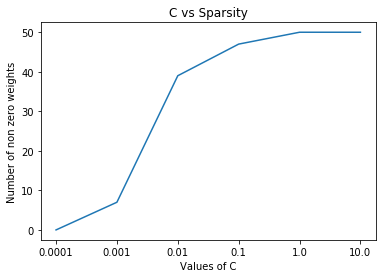

In [107]:
# Plotting C vs Sparsity
plt.title("C vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of non zero weights")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), spc)
plt.show()

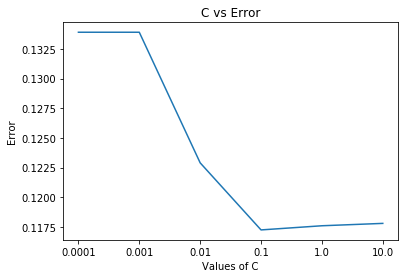

In [108]:
# Plotting C vs Error.
plt.title("C vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.xticks(range(len(C_sparse)), C_sparse)
plt.plot(range(len(C_sparse)), error)
plt.show()

##### Pertubation Test :

In [109]:
# Adding noise to matrix
epsilon = 0.000001
train_tfidf_2 = np.array(train_tfidf) + epsilon

In [110]:
model_2 = LogisticRegression(C=1, penalty='l2')
model_2.fit(train_tfidf_2, y_tfidf_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [111]:
# Finding percentage change :
# Adding a very small value to avoid divison by zero error
w = model.coef_ + 0.0000001
w_dash = model_2.coef_

# Percentage change = (original - changed)/original * 100
diff = w - w_dash
change = diff*1.0/w
percentage_change = change * 100
percentage_change = percentage_change[0]

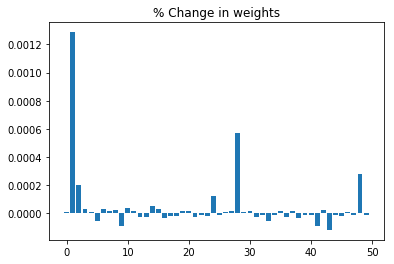

In [113]:
plt.bar(height=percentage_change, x = [i for i in range(len(percentage_change))])
plt.title("% Change in weights")
plt.show()

## Conclusions :


<table>
  <tr>
    <th>Featurization</th>
    <th>Train ROC_AUC</th>
    <th>Test ROC_AUC</th>
    <th>CV ROC_AUC</th>
    <th>C</th>
    <th>Penalty</th>
  </tr>
  <tr>
    <td>BOW</td>
    <td>0.9583</td>
    <td>0.9401</td>
    <td>0.9431</td>
    <td>0.1</td>
    <td>L2</td>
  </tr>
  <tr>
    <td>TFIDF</td>
    <td>0.9605</td>
    <td>0.9504</td>
    <td>0.9534</td>
    <td>1</td>
    <td>L2</td>
  </tr>
  <tr>
    <td>AVG-W2V</td>
    <td>0.9221</td>
    <td>0.9234</td>
    <td>0.9284</td>
    <td>1</td>
    <td>L2</td>
  </tr>
  <tr>
    <td>TFIDF</td>
    <td>0.8648</td>
    <td>0.8665</td>
    <td>0.8675</td>
    <td>1</td>
    <td>L2</td>
  </tr>
</table>